# Correlation analysis

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Compute a time series where the element x(t) represents the amount of time spent walking in the 48
hours before t . Put it into a vector representing the values of x(t) at 15-minute intervals (so that if the
first element is at t
= 14:00, the second should be at t = 14:15).

In [2]:
motion = open('motion.tsv','r')

#   floor_time: keeps the relevant (current) 15 min. interval stamp.
#   time: keeps the last time stamp read from file.
#   new_time: the new time stamp read from file.

floor_time = datetime.strptime('2017-05-23T05:45:00.00+00:00', "%Y-%m-%dT%H:%M:%S.%f+00:00")
walking_dur = [timedelta(minutes=0)]
walk_flag = 0
qh = timedelta(minutes=15) # quarter-hour

for line in motion:
    stamp = line.split("\t")
    new_time = datetime.strptime(stamp[0], "%Y-%m-%dT%H:%M:%S.%f+00:00")
    if walk_flag:
        walking_dur[-1] = walking_dur[-1] + (new_time-time)
    walk_flag = int(stamp[2])
    time = new_time
    
    # restart counting every 15 min.
    if time-floor_time > qh:
        floor_time = floor_time + qh
        walking_dur.append(timedelta(minutes=0))
        
walk_array = np.array([i.total_seconds() for i in walking_dur])
temp = np.cumsum(walk_array)
y1 = temp[(60/15)*48:]-temp[:-(60/15)*48]


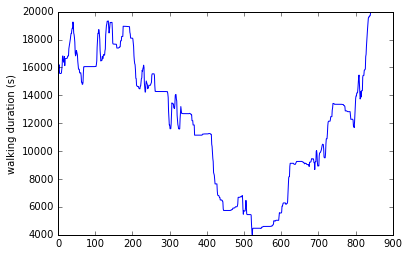

In [3]:
plt.plot(y1)
plt.ylabel('walking duration (s)')
plt.show()

Then, compute a vector from Blood Glucose levels where each element is the standard deviation of
Blood Glucose levels in the last 48 hours. Again, elements of this vector are separated by an interval
of 15 minutes. The time span covered by this vector should be the same as the one before (in other
words, the two vectors should be parallel). Feel free to interpolate missing values.

In [4]:
motion = open('blood-glucose.csv','r')
time_stamps = []
glucose = []
for line in motion:
    stamp = line.split(",")
    time = datetime.strptime(stamp[0], "%Y-%m-%d %H:%M:%S+00:00")
    time_stamps.append(time)
    glucose.append(stamp[1])
glucose = np.array([ float(g.replace('\n','0')) for g in glucose])
glucose[glucose == 0] = 'nan' #ignore 0 values
time_stamps = time_stamps[23+(60/15)*48:]
glucose = glucose[23:] # trim irrelevant data

y2 = np.array([])
for i in range(len(glucose)-(60/15)*48):
    y2 = np.append(y2,np.nanstd(glucose[i:(i+(60/15)*48)]))

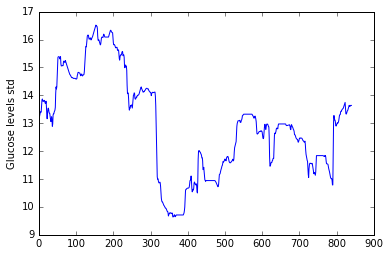

In [5]:
plt.plot(y2)
plt.ylabel('Glucose levels std')
plt.show()

Plot these two time series and check from a purely statistical point of view whether these two time
series are correlated in some way, describing the meaning of your test

[[ 1.          0.58370289]
 [ 0.58370289  1.        ]]


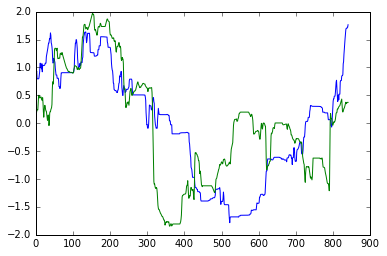

In [6]:
print np.corrcoef(y1,y2)
y1n = (y1-y1.mean())/y1.std()
y2n = (y2-y2.mean())/y2.std()
plt.plot(y1n)
plt.plot(y2n)
plt.show()

We measured the linear correlation between the two variables as 0.58370289. 1 would be a total (positive) correlation and 0 would mean no linear correlation. Meaning that the divergence of each variable from its mean is correlated with the other variable to some extent.

Train a model that predicts the value of Blood Glucose levels standard deviation at time t using the
amount of walking at time t, and evaluate how well it performs.

In [7]:
train = np.random.rand(len(y1)) < 0.8
x_train = y1[train]
y_train = y2[train]
p = np.poly1d(np.polyfit(x_train, y_train, 10))

mean squere error:  0.765401577317


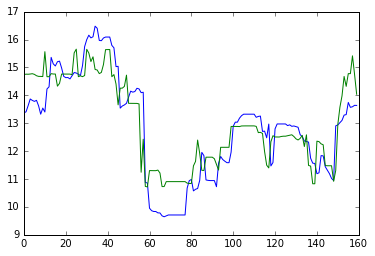

In [8]:
x_test = y1[~train]
y_test = y2[~train]
y_tag = p(x_test)
plt.plot(y_test)
plt.plot(y_tag)
print "mean squere error: ", sum((y_tag-y_test)**2)/len(y_test)

I used a 10 degree polynomial model to fit the training data and then predict the test samples. At this point I was out of time. I would continue by trying different polynomial degrees and use cross-validation to determine at which point (polynomial degree) the model begins to overfit the training data.

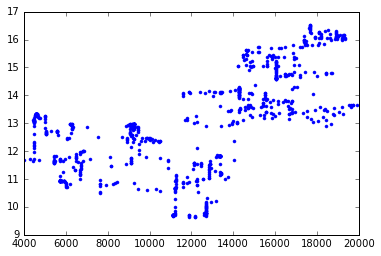

In [9]:
plt.plot(y1,y2,'.')

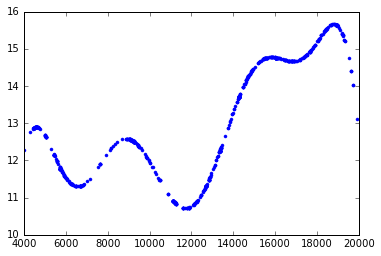

In [11]:
plt.plot(y1,p(y1),'.')